In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import keras
from keras.models import Sequential
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM, SimpleRNN
## sequence in both forward and backward directions
from keras.layers import Bidirectional
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
%matplotlib inline
import math


from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:

!wget --no-check-certificate \
    "http://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download" \
    -O "/tmp/pollution_data.zip"

system_zip = '/tmp/pollution_data.zip'
zip   = zipfile.ZipFile(system_zip, 'r')
zip.extractall('/tmp')
zip.close()

--2022-12-22 03:19:37--  http://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download
Resolving cmshare.eea.europa.eu (cmshare.eea.europa.eu)... 87.54.7.179
Connecting to cmshare.eea.europa.eu (cmshare.eea.europa.eu)|87.54.7.179|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download [following]
--2022-12-22 03:19:38--  https://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download
Connecting to cmshare.eea.europa.eu (cmshare.eea.europa.eu)|87.54.7.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103636023 (99M) [application/zip]
Saving to: ‘/tmp/pollution_data.zip’

/tmp/pollution_data 100%[===================>]  98.83M  1.09MB/s    in 33s     

2022-12-22 03:20:12 (3.02 MB/s) - ‘/tmp/pollution_data.zip’ saved [103636023/103636023]



In [3]:
system_zip = '/tmp/pollution_data.zip'
zip   = zipfile.ZipFile(system_zip, 'r')
zip.extractall('/tmp')
zip.close()

In [4]:
project_dir = "/tmp/"
date_vars = ['DatetimeBegin','DatetimeEnd']

agg_ts = pd.read_csv(project_dir + '/BE_1_2013-2015_aggregated_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
meta = pd.read_csv(project_dir + '/BE_2013-2015_metadata.csv', sep='\t')

print(f'aggregated timeseries shape:{agg_ts.shape}')
print(f'metadata shape:{meta.shape}')

aggregated timeseries shape:(53647, 18)
metadata shape:(1289, 26)


In [5]:
agg_ts.head()

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,AirPollutant,AirPollutantCode,DataAggregationProcess,AirPollutionLevel,UnitOfAirPollutionLevel,DataCapture,DataCoverage,TimeCoverage,DatetimeBegin,DatetimeEnd,Validity,Verification
53642,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETWOL1,BETWOL1,SPO-BETWOL1_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1Y-hrsAbove350,0.000000,count,100.0,85.022831,85.022831,2015-01-01,2016-01-01,1,1
53643,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETWOL1,BETWOL1,SPO-BETWOL1_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1Y-hrsAbove350,0.000000,count,100.0,96.221461,96.221461,2013-01-01,2014-01-01,1,1
53644,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETWOL1,BETWOL1,SPO-BETWOL1_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1Y-hrsAbove350,0.000000,count,100.0,97.500000,97.500000,2014-01-01,2015-01-01,1,1
53645,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETWOL1,BETWOL1,SPO-BETWOL1_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,winter-avg,2.541153,µg/m3,100.0,96.520147,96.520147,2014-10-01,2015-04-01,1,1
53646,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETWOL1,BETWOL1,SPO-BETWOL1_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,winter-avg,3.920979,µg/m3,100.0,98.214286,98.214286,2013-10-01,2014-04-01,1,1


In [6]:
print(agg_ts.DatetimeBegin.value_counts()[:5])
print(agg_ts.DatetimeEnd.value_counts()[:5])

2013-01-01    693
2014-01-01    659
2015-01-01    623
2013-10-01     95
2014-10-01     93
Name: DatetimeBegin, dtype: int64
2014-01-01    691
2015-01-01    658
2016-01-01    621
2015-04-01     95
2014-04-01     90
Name: DatetimeEnd, dtype: int64


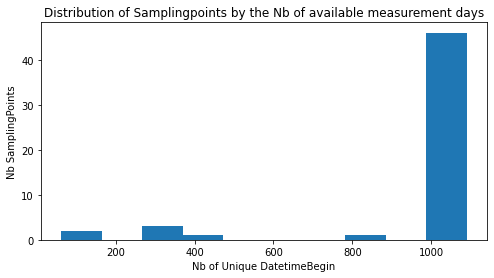

In [7]:
ser_avail_days = agg_ts.groupby('SamplingPoint').nunique()['DatetimeBegin']
plt.figure(figsize=(8,4))
plt.hist(ser_avail_days.sort_values(ascending=False))
plt.ylabel('Nb SamplingPoints')
plt.xlabel('Nb of Unique DatetimeBegin')
plt.title('Distribution of Samplingpoints by the Nb of available measurement days')
plt.show()

In [8]:
df = agg_ts.loc[agg_ts.DataAggregationProcess=='P1D', :] 
df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
df.drop(columns=vars_to_drop, axis='columns', inplace=True)

In [9]:
dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
samplingpoints = list(df.SamplingPoint.unique())

new_idx = []
for sp in samplingpoints:
    for d in dates:
        new_idx.append((sp, np.datetime64(d)))

df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
df.sort_index(inplace=True)
df = df.reindex(new_idx)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # should contain NaN for the columns

df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # NaN are replaced by values of 2013-01-30
print('{} missing values'.format(df.isnull().sum().sum()))

0 missing values


In [10]:
df = df.loc['SPO-BETR223_00001_100',:] 

In [11]:
df.head()

,AirPollutionLevel
DatetimeBegin,
2013-01-01,1.847826
2013-01-02,0.000000
2013-01-03,0.000000
2013-01-04,0.000000
2013-01-05,0.000000


In [12]:
train = df.query('DatetimeBegin < "2014-07-01"')
valid = df.query('DatetimeBegin >= "2014-07-01" and DatetimeBegin < "2015-01-01"')
test = df.query('DatetimeBegin >= "2015-01-01"')

In [13]:
# Save column names
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [14]:
train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)
train.to_csv('/tmp/train.csv')
valid.to_csv('/tmp/valid.csv')
test.to_csv('/tmp/test.csv')

In [15]:
train = pd.read_csv('/tmp/train.csv', header=0, index_col=0).values.astype('float32')
valid = pd.read_csv('/tmp/valid.csv', header=0, index_col=0).values.astype('float32')
test = pd.read_csv('/tmp/test.csv', header=0, index_col=0).values.astype('float32')

def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [16]:
n_lag = 50

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=50, batch_size = 5)
valid_data_gen = TimeseriesGenerator(valid, valid, length=n_lag, sampling_rate=1, stride=500, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=50, batch_size = 1)

**Bidirectional RNN**

Epoch 1/1000
2/2 [==============================] - 2s 452ms/step - loss: 0.6403 - val_loss: 0.0213
Epoch 2/1000
2/2 [==============================] - 0s 117ms/step - loss: 0.4978 - val_loss: 0.0604
Epoch 3/1000
2/2 [==============================] - 0s 118ms/step - loss: 0.4106 - val_loss: 0.0933
Epoch 4/1000
2/2 [==============================] - 0s 115ms/step - loss: 0.3609 - val_loss: 0.1110
Epoch 5/1000
2/2 [==============================] - 0s 100ms/step - loss: 0.3275 - val_loss: 0.1294
Epoch 6/1000
2/2 [==============================] - 0s 110ms/step - loss: 0.2972 - val_loss: 0.1491
Epoch 7/1000
2/2 [==============================] - 0s 121ms/step - loss: 0.2716 - val_loss: 0.1458
Epoch 8/1000
2/2 [==============================] - 0s 117ms/step - loss: 0.2543 - val_loss: 0.1446
Epoch 9/1000
2/2 [==============================] - 0s 133ms/step - loss: 0.2378 - val_loss: 0.1468
Epoch 10/1000
2/2 [==============================] - 0s 109ms/step - loss: 0.2215 - val_loss: 0.1483

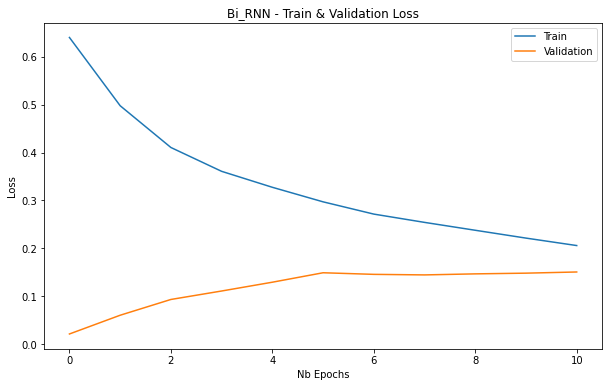

Minimum validation loss of 0.02128767967224121 reached at epoch 0


In [17]:
bi_rnn = Sequential()
bi_rnn.add(Bidirectional(SimpleRNN(4, input_shape=(n_lag, 1),return_sequences=True)))
bi_rnn.add(SimpleRNN(8))
bi_rnn.add(Dense(1))
bi_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='/tmp/bi_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("/tmp/bi_rnn.json", "w") as m:
    m.write(bi_rnn.to_json())

bi_rnn_history = bi_rnn.fit(train_data_gen
                                              , epochs=1000
                                              , validation_data=valid_data_gen
                                              , verbose=1
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(bi_rnn_history, 'Bi_RNN - Train & Validation Loss')

In [18]:
#Make pedictions
trainPredict = bi_rnn.predict(train_data_gen)
testPredict = bi_rnn.predict(test_data_gen)

7/7 [==============================] - 0s 13ms/step


In [19]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

Increase the size of the time series three times

In [20]:
n_lag = 150

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=150, batch_size = 5)
valid_data_gen = TimeseriesGenerator(valid, valid, length=n_lag, sampling_rate=1, stride=150, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=150, batch_size = 1)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.2383 - val_loss: 0.2124
Epoch 2/1000
1/1 [==============================] - 0s 295ms/step - loss: 0.1747 - val_loss: 0.1717
Epoch 3/1000
1/1 [==============================] - 0s 294ms/step - loss: 0.1266 - val_loss: 0.1368
Epoch 4/1000
1/1 [==============================] - 0s 336ms/step - loss: 0.0837 - val_loss: 0.1038
Epoch 5/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.0583 - val_loss: 0.0904
Epoch 6/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.0463 - val_loss: 0.0786
Epoch 7/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.0435 - val_loss: 0.0884
Epoch 8/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.0388 - val_loss: 0.0598
Epoch 9/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.0440 - val_loss: 0.0685
Epoch 10/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.0318 - val_loss: 0.0753
Ep

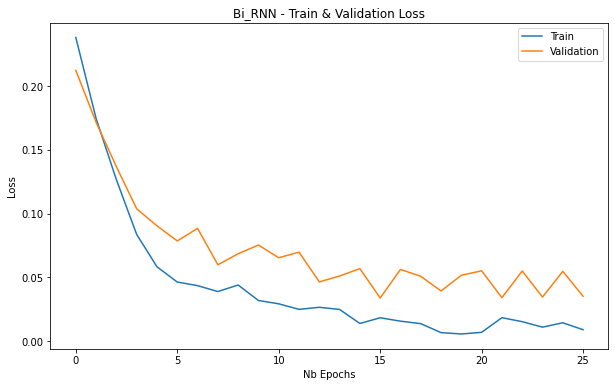

Minimum validation loss of 0.03379276394844055 reached at epoch 15


In [21]:
bi_rnn = Sequential()
bi_rnn.add(Bidirectional(SimpleRNN(4, input_shape=(n_lag, 1),return_sequences=True)))
bi_rnn.add(SimpleRNN(8))
bi_rnn.add(Dense(1))
bi_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='/tmp/bi_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("/tmp/bi_rnn.json", "w") as m:
    m.write(bi_rnn.to_json())

bi_rnn_history = bi_rnn.fit(train_data_gen
                                              , epochs=1000
                                              , validation_data=valid_data_gen
                                              , verbose=1
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(bi_rnn_history, 'Bi_RNN - Train & Validation Loss')

In [22]:
#Make pedictions
trainPredict = bi_rnn.predict(train_data_gen)
testPredict = bi_rnn.predict(test_data_gen)

2/2 [==============================] - 0s 36ms/step


In [23]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

In [24]:
traindf = df[ : int(0.7 * len(df))]
testdf = df[int(0.85 * len(df)) : ]
valdf = df[int(0.7 * len(df)) : int(0.85 * len(df))]



In [25]:
length = 50
train_gen = TimeseriesGenerator(traindf.values, traindf.values, length = 50, batch_size = 16, stride = 50)
test_gen = TimeseriesGenerator(testdf.values, testdf.values, length = 50, batch_size = 1, stride = 50)
val_gen = TimeseriesGenerator(valdf.values, valdf.values, length = 50, batch_size = 1, stride = 50)

**GRU Model**

In [26]:
n_input = 50
n_features = 1
batch_size = 1
model = Sequential()
model.add(keras.layers.GRU(80, activation = 'relu', input_shape = (n_input, n_features), return_sequences = True))
model.add(keras.layers.GRU(60, activation = 'relu', return_sequences = True))
model.add(keras.layers.GRU(40, activation = 'relu'))
model.add(Dense(12, activation = 'softmax'))
adam = keras.optimizers.Adam(lr = 5e-4)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
history = model.fit_generator(train_gen, validation_data = val_gen, epochs = 1000, verbose = 1)

Epoch 1/1000


<ipython-input-27-f7f1d3a100a5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, validation_data = val_gen, epochs = 1000, verbose = 1)


1/1 [==============================] - 3s 3s/step - loss: 122.5524 - accuracy: 0.0000e+00 - val_loss: 18.8054 - val_accuracy: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 327ms/step - loss: 122.5168 - accuracy: 0.0000e+00 - val_loss: 18.8037 - val_accuracy: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - 0s 326ms/step - loss: 122.4877 - accuracy: 0.0000e+00 - val_loss: 18.8027 - val_accuracy: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - 0s 332ms/step - loss: 122.4692 - accuracy: 0.0000e+00 - val_loss: 18.8024 - val_accuracy: 0.0000e+00
Epoch 5/1000
1/1 [==============================] - 0s 329ms/step - loss: 122.4634 - accuracy: 0.0000e+00 - val_loss: 18.8024 - val_accuracy: 0.0000e+00
Epoch 6/1000
1/1 [==============================] - 0s 342ms/step - loss: 122.4629 - accuracy: 0.0000e+00 - val_loss: 18.8026 - val_accuracy: 0.0000e+00
Epoch 7/1000
1/1 [==============================] - 0s 333ms/step - loss: 122.4656 - accuracy: 0.0

In [28]:
model.evaluate_generator(test_gen)

<ipython-input-28-162faf28a7af>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen)


[nan, 1.0]

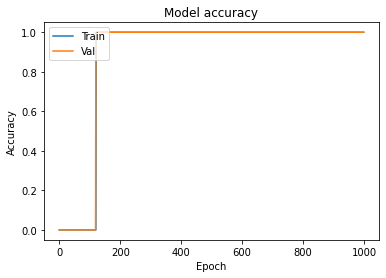

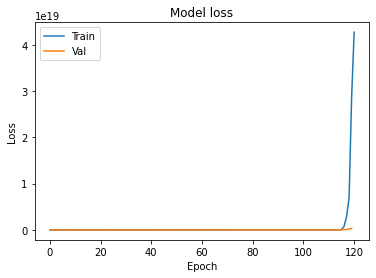

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [30]:
#Make pedictions
trainPredict = model.predict(train_gen)
testPredict = model.predict(test_gen)

3/3 [==============================] - 0s 25ms/step


In [31]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

Increase the size of the time series three times

In [32]:
length = 150
train_gen = TimeseriesGenerator(traindf.values, traindf.values, length = 150, batch_size = 16, stride = 1)
test_gen = TimeseriesGenerator(testdf.values, testdf.values, length = 150, batch_size = 1, stride = 1)
val_gen = TimeseriesGenerator(valdf.values, valdf.values, length = 150, batch_size = 1, stride = 1)

In [33]:
n_input = 150
n_features = 1
batch_size = 1
model = Sequential()
model.add(keras.layers.GRU(80, activation = 'relu', input_shape = (n_input, n_features), return_sequences = True))
model.add(keras.layers.GRU(60, activation = 'relu', return_sequences = True))
model.add(keras.layers.GRU(40, activation = 'relu'))
model.add(Dense(12, activation = 'softmax'))
adam = keras.optimizers.Adam(lr = 5e-4)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
history = model.fit_generator(train_gen, validation_data = val_gen, epochs = 1000, verbose = 1)

Epoch 1/1000


<ipython-input-34-f7f1d3a100a5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, validation_data = val_gen, epochs = 1000, verbose = 1)


39/39 [==============================] - 30s 693ms/step - loss: 93.6004 - accuracy: 0.0000e+00 - val_loss: 49.1644 - val_accuracy: 0.0000e+00
Epoch 2/1000
39/39 [==============================] - 27s 680ms/step - loss: 486300.2188 - accuracy: 0.0000e+00 - val_loss: 1475915.3750 - val_accuracy: 0.0000e+00
Epoch 3/1000
39/39 [==============================] - 27s 683ms/step - loss: nan - accuracy: 0.9221 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/1000
39/39 [==============================] - 27s 685ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/1000
39/39 [==============================] - 27s 685ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/1000
39/39 [==============================] - 26s 672ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/1000
39/39 [==============================] - 26s 672ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000

KeyboardInterrupt: ignored

In [35]:
model.evaluate_generator(test_gen)

<ipython-input-35-162faf28a7af>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen)


[nan, 1.0]

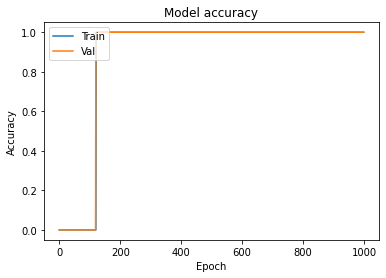

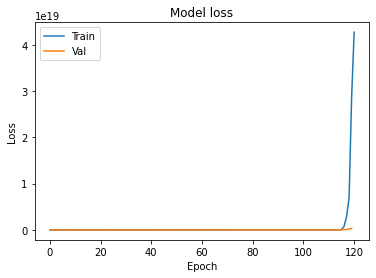

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [37]:
#Make pedictions
trainPredict = model.predict(train_gen)
testPredict = model.predict(test_gen)

15/15 [==============================] - 1s 70ms/step


In [38]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

**LSTM Model**

In [39]:
length = 50
train_gen = TimeseriesGenerator(traindf.values, traindf.values, length = 50, batch_size = 16, stride = 1)
test_gen = TimeseriesGenerator(testdf.values, testdf.values, length = 50, batch_size = 1, stride = 1)
val_gen = TimeseriesGenerator(valdf.values, valdf.values, length = 50, batch_size = 1, stride = 1)

Epoch 1/1000


<ipython-input-40-f7afd52bcce2>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  lstm_history = lstm.fit_generator(train_data_gen


1/1 [==============================] - 5s 5s/step - loss: 0.0983 - val_loss: 0.1780
Epoch 2/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0869 - val_loss: 0.1697
Epoch 3/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0788 - val_loss: 0.1630
Epoch 4/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0722 - val_loss: 0.1570
Epoch 5/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0664 - val_loss: 0.1517
Epoch 6/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0611 - val_loss: 0.1467
Epoch 7/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0562 - val_loss: 0.1420
Epoch 8/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0516 - val_loss: 0.1375
Epoch 9/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0473 - val_loss: 0.1332
Epoch 10/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0431 - val_loss: 0.1291
Epoch 11/1000
1/1 [=====

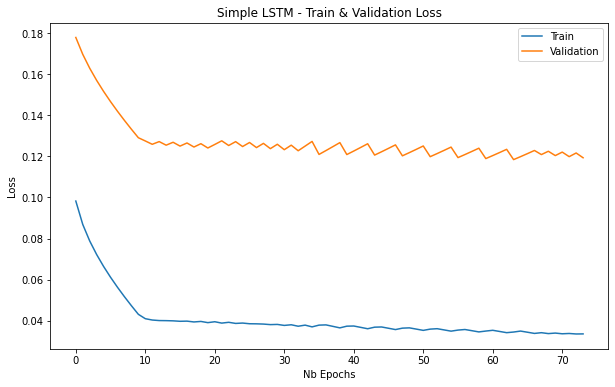

Minimum validation loss of 0.1184428334236145 reached at epoch 63


In [40]:
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
#Simple LSTM
lstm = Sequential()
lstm.add(LSTM(4, input_shape=(n_lag, 1)))
lstm.add(Dense(1))
lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='/tmp/lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("/tmp/lstm.json", "w") as m:
    m.write(lstm.to_json())

lstm_history = lstm.fit_generator(train_data_gen
                                                , epochs=1000
                                                , validation_data=valid_data_gen
                                                , verbose=1
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(lstm_history, 'Simple LSTM - Train & Validation Loss')

In [41]:
#Make pedictions
trainPredict = lstm.predict(train_data_gen)
testPredict = lstm.predict(test_data_gen)

2/2 [==============================] - 0s 5ms/step


In [42]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

Increase the size of the time series three times

In [43]:
length = 150
train_gen = TimeseriesGenerator(traindf.values, traindf.values, length = 150, batch_size = 16, stride = 1)
test_gen = TimeseriesGenerator(testdf.values, testdf.values, length = 150, batch_size = 1, stride = 1)
val_gen = TimeseriesGenerator(valdf.values, valdf.values, length = 150, batch_size = 1, stride = 1)

Epoch 1/1000


<ipython-input-44-3e230da206e6>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  lstm_history = lstm.fit_generator(train_data_gen


1/1 [==============================] - 2s 2s/step - loss: 0.1452 - val_loss: 0.2359
Epoch 2/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1334 - val_loss: 0.2271
Epoch 3/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.1247 - val_loss: 0.2196
Epoch 4/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1174 - val_loss: 0.2129
Epoch 5/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1108 - val_loss: 0.2067
Epoch 6/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1047 - val_loss: 0.2008
Epoch 7/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0990 - val_loss: 0.1951
Epoch 8/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0935 - val_loss: 0.1897
Epoch 9/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0881 - val_loss: 0.1843
Epoch 10/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0829 - val_loss: 0.1791
Epoch 11/1000
1/1 [=====

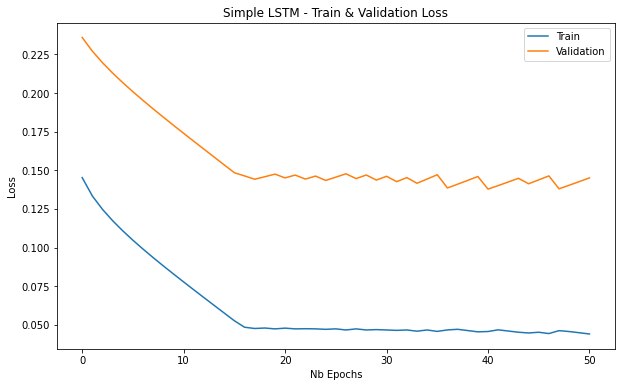

Minimum validation loss of 0.13781008124351501 reached at epoch 40


In [44]:
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
# LSTM
lstm = Sequential()
lstm.add(LSTM(4, input_shape=(n_lag, 1)))
lstm.add(Dense(1))
lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='/tmp/lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("/tmp/lstm.json", "w") as m:
    m.write(lstm.to_json())

lstm_history = lstm.fit_generator(train_data_gen
                                                , epochs=1000
                                                , validation_data=valid_data_gen
                                                , verbose=1
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(lstm_history, 'Simple LSTM - Train & Validation Loss')

In [45]:
#Make pedictions
trainPredict = lstm.predict(train_data_gen)
testPredict = lstm.predict(test_data_gen)

2/2 [==============================] - 0s 5ms/step


In [46]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

### Deep RNNs

Keras library allows to use different types of layers for neural networks. Probably the best type of layer for RNN - recurrent neural network is LSTM layer or long short-term memory. Here is more information about it: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [47]:
length = 50
train_gen = TimeseriesGenerator(traindf.values, traindf.values, length = 50, batch_size = 16, stride = 1)
test_gen = TimeseriesGenerator(testdf.values, testdf.values, length = 50, batch_size = 1, stride = 1)
val_gen = TimeseriesGenerator(valdf.values, valdf.values, length = 50, batch_size = 1, stride = 1)

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1144 - val_loss: 0.1376
Epoch 2/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.0490 - val_loss: 0.0430
Epoch 3/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0570 - val_loss: 0.0859
Epoch 4/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0451 - val_loss: 0.1090
Epoch 5/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0377 - val_loss: 0.1261
Epoch 6/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0399 - val_loss: 0.0369
Epoch 7/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0472 - val_loss: 0.1296
Epoch 8/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0428 - val_loss: 0.0897
Epoch 9/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0398 - val_loss: 0.0997
Epoch 10/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0359 - val_loss: 0.1092
Epoch 11/10

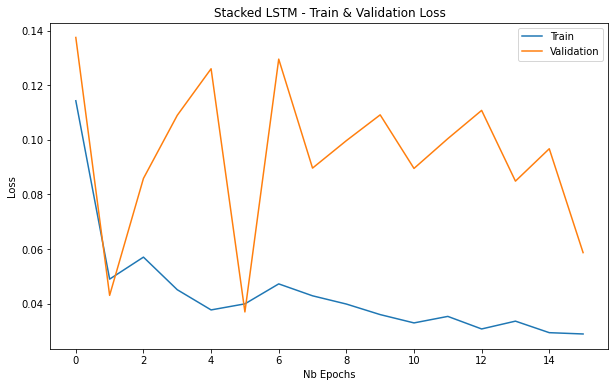

Minimum validation loss of 0.03692558407783508 reached at epoch 5


In [48]:
deep_rnn = Sequential()
deep_rnn.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
deep_rnn.add(LSTM(32, return_sequences=True))
deep_rnn.add(LSTM(64))
deep_rnn.add(Dense(1))
deep_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='/tmp/deep_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("/tmp/deep_rnn.json", "w") as m:
    m.write(deep_rnn.to_json())

deep_rnn_history = deep_rnn.fit(train_data_gen
                                                  , epochs=1000
                                                  , validation_data=valid_data_gen
                                                  , verbose=1
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(deep_rnn_history, 'Stacked LSTM - Train & Validation Loss')

In [49]:
#Make pedictions
trainPredict = deep_rnn.predict(train_data_gen)
testPredict = deep_rnn.predict(test_data_gen)

2/2 [==============================] - 0s 11ms/step


In [50]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

In [51]:
length = 150
train_gen = TimeseriesGenerator(traindf.values, traindf.values, length = 150, batch_size = 16, stride = 1)
test_gen = TimeseriesGenerator(testdf.values, testdf.values, length = 150, batch_size = 1, stride = 1)
val_gen = TimeseriesGenerator(valdf.values, valdf.values, length = 150, batch_size = 1, stride = 1)

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.1046 - val_loss: 0.0927
Epoch 2/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0431 - val_loss: 0.1421
Epoch 3/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.0553 - val_loss: 0.0362
Epoch 4/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0496 - val_loss: 0.1420
Epoch 5/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0549 - val_loss: 0.0994
Epoch 6/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0399 - val_loss: 0.1120
Epoch 7/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0351 - val_loss: 0.1238
Epoch 8/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0380 - val_loss: 0.1039
Epoch 9/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0344 - val_loss: 0.1176
Epoch 10/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0360 - val_loss: 0.0924
Epoch 11/10

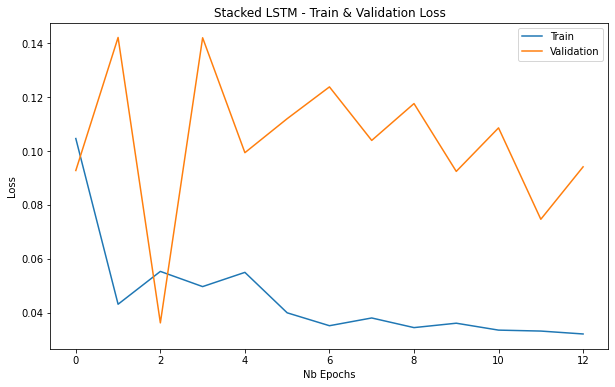

Minimum validation loss of 0.03615257143974304 reached at epoch 2


In [52]:
deep_rnn = Sequential()
deep_rnn.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
deep_rnn.add(LSTM(32, return_sequences=True))
deep_rnn.add(LSTM(64))
deep_rnn.add(Dense(1))
deep_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='/tmp/deep_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("/tmp/deep_rnn.json", "w") as m:
    m.write(deep_rnn.to_json())

deep_rnn_history = deep_rnn.fit(train_data_gen
                                                  , epochs=1000
                                                  , validation_data=valid_data_gen
                                                  , verbose=1
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(deep_rnn_history, 'Stacked LSTM - Train & Validation Loss')

In [53]:
#Make pedictions
trainPredict = deep_rnn.predict(train_data_gen)
testPredict = deep_rnn.predict(test_data_gen)

2/2 [==============================] - 0s 11ms/step


In [54]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)